Importing Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader

##**DATASET LOADING AND PREPARATION**

In [2]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(),  download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
loader_train = torch.utils.data.DataLoader(dataset=train_dataset,batch_size = len(train_dataset) ,shuffle=True) 
loader_test = torch.utils.data.DataLoader(dataset=test_dataset,batch_size = len(test_dataset) ,shuffle=True)

In [4]:
X_train,y_train=next(iter(loader_train))
X_test,y_test=next(iter(loader_test))

In [5]:
X_train=X_train.numpy()
y_train=y_train.numpy()
X_test=X_test.numpy()
y_test=y_test.numpy()

In [6]:
X_train_flattened=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3])
X_test_flattened=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3])

One-Hot Encoding

In [7]:
train_labels_encoded = []
for i in y_train:
  A=np.array([0]*10)
  A[i]=1
  train_labels_encoded.append(A)
y_train_encoded=np.array(train_labels_encoded)

In [8]:
test_labels_encoded = []
for i in y_test:
  A=np.array([0]*10)
  A[i]=1
  test_labels_encoded.append(A)
y_test_encoded=np.array(test_labels_encoded)

In [9]:
X_train_flattened_torch=torch.from_numpy(X_train_flattened)
y_train_encoded_torch=torch.from_numpy(y_train_encoded)

In [10]:
X_test_flattened_torch=torch.from_numpy(X_test_flattened)
y_test_encoded_torch=torch.from_numpy(y_test_encoded)

Here we have prepared dataset with flattenned images and one-hot encoded labels

In [11]:
Train_Dataset=TensorDataset(X_train_flattened_torch,y_train_encoded_torch)

In [12]:
Test_Dataset=TensorDataset(X_test_flattened_torch,y_test_encoded_torch)

##**HELPER FUNCTIONS**

In [13]:
def sigmoid(z):
  return 1/(1+(np.exp(-z)))

def softmax(z):
    return np.exp(z)/sum(np.exp(z))

In [14]:
def dif_sigmoid(z):
  return ((1-sigmoid(z))*sigmoid(z)) ##since diff of sigmoid is (1-sigmoid)*sigmoid

In [15]:
def glorot_initialisation(output_n,input_n):
  M=np.sqrt(6/(input_n+output_n))
  W=np.random.uniform(low=-M, high=M, size=(output_n,input_n))
  b=np.random.uniform(low=-M, high=M, size=(output_n,1))
  return W,b

In [16]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """
    
    np.random.seed(1390)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):

        # M=np.sqrt(6/(self.input_n+self.output_n))
        parameters['W' + str(l)],parameters['b' + str(l)]  = glorot_initialisation(layer_dims[l], layer_dims[l-1])
        
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
        
    return parameters

In [17]:
def forward_propagation(X, parameters):
    """

    SHAPE OF X = 784,samples(i.e. 64 for a batch)
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3","W4","b4":
                    W1 -- weight matrix of shape (500,784)
                    b1 -- bias vector of shape (500,1)
                    W2 -- weight matrix of shape (250,500)
                    b2 -- bias vector of shape (250,1)
                    W3 -- weight matrix of shape (100,250)
                    b3 -- bias vector of shape (100,1)
                    W4 -- weight matrix of shape (10,100)
                    b4 -- bias vector of shape (10,1)

    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """

    cache={}
      

    cache['Z2']=np.dot(parameters['W1'],X)+parameters['b1']
    cache['A2']=sigmoid(cache['Z2'])

    cache['Z3']=np.dot(parameters['W2'],cache['A2'])+parameters['b2']
    cache['A3']=sigmoid(cache['Z3'])

    cache['Z4']=np.dot(parameters['W3'],cache['A3'])+parameters['b3']
    cache['A4']=sigmoid(cache['Z4'])

    cache['Z5']=np.dot(parameters['W4'],cache['A4'])+parameters['b4']
    cache['A5']=softmax(cache['Z5'])

    A_last=cache['A5']

    cache['W1']=parameters['W1']
    cache['b1']=parameters['b1']   
        
    cache['W2']=parameters['W2']
    cache['b2']=parameters['b2']   
    
    cache['W3']=parameters['W3']
    cache['b3']=parameters['b3']   

    cache['W4']=parameters['W4']
    cache['b4']=parameters['b4']   

   # cache = {"W1": W1, "b1": b1,"Z2": Z2, "A2": A2, 
   #          "W2": W2, "b2": b2,"Z3": Z3, "A3": A3,
   #          "W3": W3, "b3": b3,"Z4": Z4, "A4": A4,
   #          "W4": W4, "b4": b4,"Z5": Z5, "A5": A5}
    
    return A_last, cache

In [18]:
# Calculating the loss function using the cross entropy
"""Arguments:
    A -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as A

    Returns:
    cost - value of the cost function
"""
def compute_cost(A, Y):    
    #A is predicted
    #Y is actual
    m = Y.shape[1] 
    logprobs = np.multiply(-np.log(A),Y) + np.multiply(-np.log(1 - A), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    return cost

In [19]:
def backward_propagation(X,Y,cache):

  m=X.shape[1]

  grads={}

  grads['dZ5']=cache['A5']-Y
  grads['dW4']= 1./m * np.dot(grads['dZ5'],cache['A4'].T)
  grads['db4']= 1./m * np.sum(grads['dZ5'],axis=1,keepdims=True)

  grads['dA4']=np.dot(cache['W4'].T,grads['dZ5'])
  grads['dZ4']=np.multiply(grads['dA4'],dif_sigmoid(cache['Z4']))
  grads['dW3']=1./m * np.dot(grads['dZ4'],cache['A3'].T)
  grads['db3']=1./m * np.sum(grads['dZ4'],axis=1,keepdims=True)

  grads['dA3']=np.dot(cache['W3'].T,grads['dZ4'])
  grads['dZ3']=np.multiply(grads['dA3'],dif_sigmoid(cache['Z3']))
  grads['dW2']=1./m * np.dot(grads['dZ3'],cache['A2'].T)
  grads['db2']=1./m * np.sum(grads['dZ3'],axis=1,keepdims=True)

  grads['dA2']=np.dot(cache['W2'].T,grads['dZ3'])
  grads['dZ2']=np.multiply(grads['dA2'],dif_sigmoid(cache['Z2']))
  grads['dW1']=1./m * np.dot(grads['dZ2'],X.T)
  grads['db1']=1./m * np.sum(grads['dZ2'],axis=1,keepdims=True)


  return grads


In [20]:
def update_parameters(parameters,grads,learning_rate):

  updated_parameters={}

  updated_parameters['W1']=parameters['W1']-learning_rate*grads['dW1']
  updated_parameters['b1']=parameters['b1']-learning_rate*grads['db1']

  updated_parameters['W2']=parameters['W2']-learning_rate*grads['dW2']
  updated_parameters['b2']=parameters['b2']-learning_rate*grads['db2']

  updated_parameters['W3']=parameters['W3']-learning_rate*grads['dW3']
  updated_parameters['b3']=parameters['b3']-learning_rate*grads['db3']

  updated_parameters['W4']=parameters['W4']-learning_rate*grads['dW4']
  updated_parameters['b4']=parameters['b4']-learning_rate*grads['db4']

  return updated_parameters

In [21]:
#Finding the accuracy of the parameter at the output 
"""  
    Arguments:
    y_actual -  given in the dataset / also called as the ground truth 
    y_pred - generated from the neural network , after a series of forward and backprop 
    
    Returns:
    accuracy =  finding the matches of the prdicted vs the actual
"""
def calculate_accuracy(y_actual,y_pred):
    accuracy = np.count_nonzero(np.argmax(y_pred,axis=0)==np.argmax(y_actual,axis=0))/y_actual.shape[1]
    return accuracy

In [22]:
def predict(X,Y,parameters):

    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- data set of examples
    parameters -- parameters of the trained model
    
    Returns:
    ypred -- predictions for the given dataset X
    """

    y_pred,cache=forward_propagation(X,parameters)
    return y_pred

##**MODEL TRAINING**

In [23]:
def model(Train_Dataset,layer_dimensions,total_epochs=15,Batch_Size=64,learning_rate=0.01):

  costs=[]
  accuracy=[]

  parameters=initialize_parameters(layer_dimensions)
  num_iterations=len(Train_Dataset)//Batch_Size


  for epoch in range(total_epochs):
    for iteration in range(num_iterations):
      Data_Loader=torch.utils.data.DataLoader(dataset=Train_Dataset,batch_size=64, shuffle=True)
      
      data_iter=iter(Data_Loader)
      Data=next(data_iter)
      X,y=Data #X.shape=(batch_size,784) y.shape=(batch_size,10)
      X=X.numpy()
      y=y.numpy()
      a5,cache=forward_propagation(X.T,parameters)
      cost=compute_cost(a5,y.T)
      gradients=backward_propagation(X.T,y.T,cache)
      parameters=update_parameters(parameters,gradients,learning_rate)

      if iteration%200==0:
        print("epoch: ",epoch+1,"/",total_epochs, "  iteration= ",iteration+1,"/",num_iterations, "  Loss: ",cost)
      accuracy.append(calculate_accuracy(y.T,a5))
      costs.append(cost)

  return accuracy,costs,parameters



In [24]:
layer_dimensions=[784,500,250,100,10]
Train_accuracy,Train_costs,Trained_parameters=model(Train_Dataset,layer_dimensions,15,64,0.01)

epoch:  1 / 15   iteration=  1 / 937   Loss:  3.528933913473381
epoch:  1 / 15   iteration=  201 / 937   Loss:  3.2295368549473595
epoch:  1 / 15   iteration=  401 / 937   Loss:  3.242631231086987
epoch:  1 / 15   iteration=  601 / 937   Loss:  3.2512596589972222
epoch:  1 / 15   iteration=  801 / 937   Loss:  3.2301902686212207
epoch:  2 / 15   iteration=  1 / 937   Loss:  3.2447326250897324
epoch:  2 / 15   iteration=  201 / 937   Loss:  3.2324886265456714
epoch:  2 / 15   iteration=  401 / 937   Loss:  3.2333129665809
epoch:  2 / 15   iteration=  601 / 937   Loss:  3.240644758292385
epoch:  2 / 15   iteration=  801 / 937   Loss:  3.2188152128410774
epoch:  3 / 15   iteration=  1 / 937   Loss:  3.202937459221192
epoch:  3 / 15   iteration=  201 / 937   Loss:  3.2384451696367775
epoch:  3 / 15   iteration=  401 / 937   Loss:  3.2243901901273264
epoch:  3 / 15   iteration=  601 / 937   Loss:  3.21005947468937
epoch:  3 / 15   iteration=  801 / 937   Loss:  3.196689693254491
epoch:  4 /

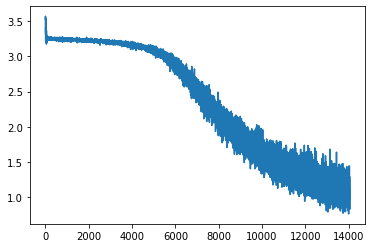

In [25]:
plt.plot(Train_costs)

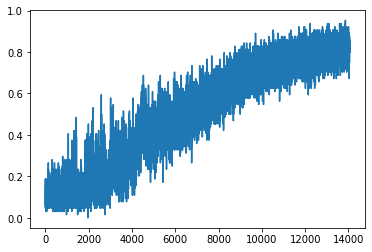

In [26]:
plt.plot(Train_accuracy)

In [27]:
Train_accuracy[-1]

0.875

In [28]:
Test_Data_Loader=torch.utils.data.DataLoader(dataset=Test_Dataset,batch_size=len(Test_Dataset),shuffle=True)
data_iter=iter(Test_Data_Loader)
Test_Data=next(data_iter)
X,y=Test_Data #X.shape=(batch_size,784) y.shape=(batch_size,10)
X=X.numpy()
y=y.numpy()
y_predicted,cache_out=forward_propagation(X.T,Trained_parameters)
cost=compute_cost(y_predicted,y.T)
Test_accuracy=calculate_accuracy(y.T,y_predicted)

In [29]:
Test_accuracy

0.8223

In [30]:
Y_Predicted=np.array(np.argmax(y_predicted,axis=0))

In [31]:
Y_Actual=np.array(np.argmax(y.T,axis=0)  )

##**CONFUSION MATRIX AND CLASSIFICATION REPORT**

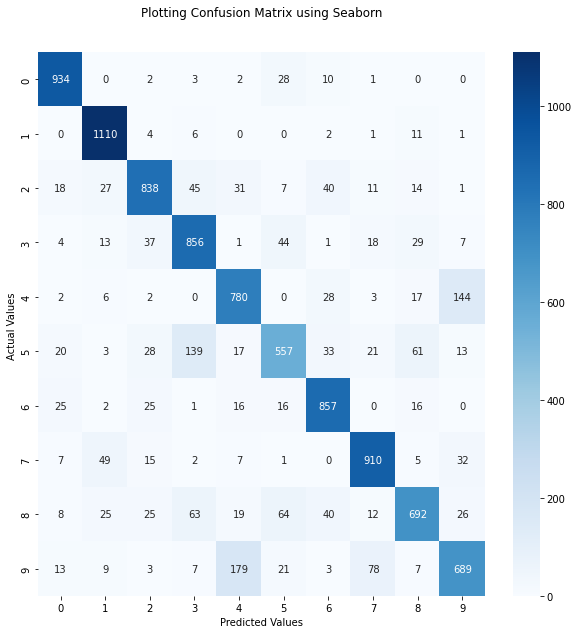

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.figure(figsize=(10,10))
conf_matrix = (confusion_matrix(Y_Actual, Y_Predicted, labels=np.unique(Y_Actual)))

# Using Seaborn heatmap to create the plot
fx = sns.heatmap(conf_matrix, annot=True, cmap='Blues',fmt='d')

# labels the title and x, y axis of plot
fx.set_title('Plotting Confusion Matrix using Seaborn\n\n');
fx.set_xlabel('Predicted Values')
fx.set_ylabel('Actual Values ');


plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(Y_Actual, Y_Predicted))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.89      0.98      0.93      1135
           2       0.86      0.81      0.83      1032
           3       0.76      0.85      0.80      1010
           4       0.74      0.79      0.77       982
           5       0.75      0.62      0.68       892
           6       0.85      0.89      0.87       958
           7       0.86      0.89      0.87      1028
           8       0.81      0.71      0.76       974
           9       0.75      0.68      0.72      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [34]:
unique_p, counts_p = np.unique(Y_Predicted, return_counts=True)

In [35]:
unique_p

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
counts_p

array([1031, 1244,  979, 1122, 1052,  738, 1014, 1055,  852,  913])

##**REPORTING ACCURACY OF MODEL**

TRAIN ACCURACY: 87.5%

TEST ACCURACY: 82.23%